Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Tutorial 2  "
COLLABORATORS = "Aakash Rajpal"

---

# 3. Categorical Mixture Model + Gibbs Sampling Algorithm

In [2]:
# Common imports 
from ast import literal_eval

import gensim
import numpy as np
import pandas as pd

import math
from typing import Tuple, Dict, List

import scipy.special

import sys
print(sys.version)

3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0]


## 1. Hyperparameters


In [3]:
K = 5 # Number of mixture components
I = 120 # Number of words in the dictionary
N = None # Number of documents

## 2. Load and preprocess the data

First, we need to load the data from the csv. This file contains the documents already processed and cleaned after applying the following steps:

1. Tokenization
2. Homogeneization, which includes:
    1. Removing capitalization.
    2. Removing non alphanumeric tokens (e.g. punktuation signs)
    3. Stemming/Lemmatization.
3. Cleaning
4. Vectorization


We load it as a `pandas` dataframe.


In [4]:
df = pd.read_csv('../../tweets_cleaned.csv')
df.drop_duplicates(subset="tweet", inplace=True)

df['tokens'] = df['tokens'].apply(literal_eval) #Transform the string into a list of tokens
X_tokens = list(df['tokens'].values)


In [5]:
print('Columns: {}\n'.format(' | '.join(df.columns.values)))

print('Tweet:\n{}'.format(df.loc[1, 'tweet']))
print('Tweet cleaned:\n{}'.format(df.loc[1, 'tweets_clean']))
print('Tweet tokens:\n{}'.format(X_tokens[1]))

Columns: tweet_id | timestamp | user_id | tweet | tweets_clean | tokens

Tweet:
OSINT people - please retweet, if possible. My friend is looking for women involved in OSINT. https://twitter.com/manisha_bot/status/1181594280336531457 …
Tweet cleaned:
osint people   please retweet  if possible  my friend is looking for women involved in osint
Tweet tokens:
['osint', 'peopl', 'retweet', 'possibl', 'friend', 'look', 'woman', 'involv', 'osint']


### Create the dictionary

Up to this point, we have transformed the raw text collection in a list of documents stored in `X_tokens`, where each document is a collection 
of the words that are most relevant for semantic analysis. Now, we need to convert these data (a list of token lists) into 
a numerical representation (a list of vectors, or a matrix). To do so, we will start using the tools provided by the `gensim` library. 

As a first step, we create a dictionary containing all tokens in our text corpus, and assigning an integer identifier to each one of them.



In [6]:
dictionary = gensim.corpora.Dictionary(X_tokens)

dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=I)

I = len(dictionary)

### Create Bag of Words (BoW): Numerical version of documents
In the second step, let us create a numerical version of our corpus using the `doc2bow` method. In general, 
`D.doc2bow(token_list)` transforms any list of tokens into a list of tuples `(token_id, n)`, one per each token in 
`token_list`, where `token_id` is the token identifier (according to dictionary `D`) and `n` is the number of occurrences 
of such token in `token_list`. 

*Exercise:* Apply the `doc2bow` method from gensim dictionary `D`, to all tokens in every document in `X_tokens`. 
The result must be a new list named `X_bow` where each element is a list of tuples `(token_id, number_of_occurrences)`.

In [7]:
X_bow = list()
keep_tweet = list()
for tweet in X_tokens:
    tweet_bow = dictionary.doc2bow(tweet)
    if len(tweet_bow) > 1:
        X_bow.append(tweet_bow)
        keep_tweet.append(True)
    else:
        keep_tweet.append(False)

df_data = df[keep_tweet]

N = len(df_data)


Finally, we transform the BoW representation `X_bow` into a matrix, namely `X_matrix`, in which the i-th row and j-th column represents the 
number of occurrences of the j-th word of the dictionary in the i-th document. This will be the matrix used in the algorithm.

In [8]:
X_matrix = np.zeros([N, I])
for i, doc_bow in enumerate(X_bow):
    word_list = list()
    for word in doc_bow:
        X_matrix[i, word[0]] = word[1]

        
print('N: {} I: {}'.format(N, I))

N: 5568 I: 120


### Exercise 1: Analytical forms of different Gibbs sampling algorithms

1. Algorithm 1

1. $p(\pi | X, Z, \theta)$

$p(\pi | X, Z, \theta) = p(\pi | Z)$\
$p(\pi | Z) \propto p(\pi , Z) = p(\pi | \alpha) p(Z | \pi)$\

$ = Dir(\pi | \alpha) \prod_{n} p(Z_{n} | \pi)$\
$ = Dir(\pi | \alpha) \prod_{n} \prod_{k} \pi_{k}^{[Z_{n} = k]}$\

Now considering $m_{k} = \sum_{n} [Z_{n} = k]$\
$ = Dir(\pi | \alpha)  \prod_{k} \pi_{k}^{m_{k}}$

$ = \frac{1}{\beta(\alpha)} \prod_{k} \pi_{k}^{\alpha_{k}  - 1}  \prod_{k} \pi_{k}^{m_{k}}$\

$p(\pi | X, Z, \theta) = Dir(\pi | \{ \alpha_{k} + m_{k}\})$






2. $p(\theta_{k} | X, Z, \pi, \theta_{-k})$

$p(\theta_{k} | X, Z, \pi, \theta_{-k}) = p(\theta_{k} | Z, X)$

$p(\theta_{k} | X, Z) \propto p(\theta_{k}, X | Z)$\
$ = p(\theta_{k} | \gamma) p(X|\theta_{k}, Z)$\
$ = Dir(\theta_k | \gamma) \prod_{n}^{N} \prod_{j}^{W_{n}} Cat(X_{nj} | \theta_{k})^{[Z_{n} = k]}$\
$ = Dir(\theta_k | \gamma) \prod_{n}^{N} \prod_{j}^{W_{n}} \prod_{m}^{|I|} Cat(X_{nj} | \theta_{k})^{[Z_{n} = k][X_{nj} = m]}$

Consider $c_{km} = \sum_{n} \sum_{j} [Z_{n} = k][X_{nj} = m]$\
$ = Dir(\theta_k | \gamma) \prod_{m}^{|I|}  \theta_{km})^{c_{km}}$

$ = Dir(\theta_k | \{\gamma_{m} + c_{km}\})$

3. $p(Z_{n} | Z_{-n}, X, \pi, \theta)$

$p(Z_{n} | Z_{-n}, X, \pi, \theta) = p(Z_{n} | X_{n}, \pi, \theta)$

$ = \frac{p(Z_{n} = k, X_{n}, | \pi, \theta)}{\sum_{k^{'}}p(Z_{n} = k, X_{n}, | \pi, \theta) }$
 
Numerator can be changed as $p(Z_{n} = k, X_{n}, | \pi, \theta) = p(Z_{n} = k | \pi) p(X_{n} | \theta_{Z_{n}})$

Again $p(Z_{n} = k | \pi) = \pi_{k}$

And $p(X_{n} | \theta_{Z_{n}}) = \prod_{j} \prod_{m} \theta_{km}^{[X_{nj} = m]}$

Substituting the same in previous expression\
$ = \frac{\pi_{k} \prod_{j} \prod_{m} \theta_{km}^{[X_{nj} = m]}}{\sum_{k^{'}} \pi_{k^{'}} \prod_{j} \prod_{m} \theta_{km}^{[X_{nj} = m]}}$

YOUR ANSWER GOES HERE

2. Algorithm 2 

YOUR ANSWER GOES HERE

2. Algorithm 3

If we integrate out the cluster means θk and mixture weights from the margial distribution of cluster assignment

$$
\begin{array}{c}
p\left(z_{i}=k \mid z_{\neg i}, \pi, \theta_{1}, \theta_{2}, \theta_{3}, \sigma, \mathbf{x}, \alpha\right) \\
p\left(z_{i} \mid z_{\neg i}, \sigma, \mathbf{x}, \alpha\right)
\end{array}
$$

By the conditional independence, we can factorize this marginal distribution


$$
\begin{aligned}
p\left(z_{i}=k \mid z_{\neg i}, \sigma, \mathbf{x}, \alpha\right) & \propto p\left(z_{i}=k \mid x_{i}, z_{\neg i}, \sigma, \mathbf{x}_{\neg i}, \alpha\right) \\
&=p\left(z_{i}=k \mid z_{\neg i}, \sigma, \mathbf{x}_{\neg i}, \alpha\right) p\left(x_{i} \mid z, \sigma, \mathbf{x}_{\neg i}, \alpha\right) \\
&=p\left(z_{i}=k \mid z_{\neg i}, \alpha\right) p\left(x_{i} \mid z, \mathbf{x}_{\neg i}, \sigma\right) \\
&=p\left(z_{i}=k \mid z_{\neg i}, \alpha\right) p\left(x_{i} \mid z_{i}=k, z_{\neg i}, x_{\neg_{i}}, \sigma\right) \\
&=p\left(z_{i}=k \mid z_{\neg i}, \alpha\right) p\left(x_{i} \mid\left\{x_{j} \mid z_{j}=k, j \neq i\right\}, \sigma\right)
\end{aligned}
$$

Because we are using a symmetric Dirichlet prior,  the predictive likelihood of a Dirichlet-categorical distribution. This is given by:
$$
p\left(z_{i}=k \mid z_{i}, \alpha\right)=\frac{N_{k}^{-i}+\alpha / K}{N-1+\alpha}
$$

 is the number of observation assigned to k (except xi)
$$
N_{k}^{-i}=\sum_{j \neq i} \delta\left(z_{j}, k\right)
$$

The second term is the predictive likelihood that point xi is distributed according to cluster k (given the data currently in cluster k)

$$
\begin{array}{c}
p\left(x_{i} \mid\left\{x_{j} \mid z_{j}=k, j \neq i\right\}, \sigma\right)=\mathcal{N}\left(x_{i} \mid \mu_{k}, \sigma_{k}^{2}+\sigma^{2}\right) \\
\sigma_{k}^{2}=\left(\frac{N_{k}^{-i}}{\sigma^{2}}+\frac{1}{\lambda_{2}^{2}}\right)^{-1} \\
\mu_{k}=\sigma_{k}^{2}\left(\frac{\lambda_{1}}{\lambda_{2}^{2}}+\frac{N_{k}^{-i} \cdot \bar{x}_{k}^{-i}}{\sigma^{2}}\right)
\end{array}
$$

Sampling $$
z_{i} \sim \frac{1}{Z_{i}} \sum_{k=1}^{K}\left(N_{k}^{-i}+\alpha / K\right) f_{k}\left(x_{i}\right) \delta\left(z_{i}, k\right)
$$

Normalizing constant $$
Z_{i}=\sum_{k=1}^{K}\left(N_{k}^{-i}+\alpha / K\right) f_{k}\left(x_{i}\right)
$$

YOUR ANSWER GOES HERE

## Exercise 2
Implement the three algorithms in the boxes below

In [9]:
def compute_lset(ns):
    return scipy.special.logsumexp(ns)

### Exercise 2.1: Implement the log likelihood of X

We provide you with the method to initialize the parameters

In [10]:
def initialize_parameters(N, K, alpha_v, gamma_v) -> Tuple[np.array, np.array, np.array]:
    pi_vector = np.random.dirichlet(alpha_v, size=1).flatten()  # [, K]
    Z_matrix = np.random.multinomial(n=1, pvals=pi_vector, size=N)  # One hot encoding Nx K
    theta_matrix = np.random.dirichlet(gamma_v, size=K)  # [K, I]
    return pi_vector, theta_matrix, Z_matrix

In [11]:
def log_likelihood_X(X, Z, theta_matrix):
    log_lik = 0
    for n in range(N):
        z_n = np.argmax(Z[n,:])
        for i in range(I):
            log_lik += X[n][i] * np.log(theta_matrix[z_n][i])
    return log_lik

In [12]:
np.random.seed(1234)

alpha_v=1*np.ones(K)
gamma_v=np.ones(I)

pi_vector, theta_matrix, Z_matrix =  initialize_parameters(N, K, alpha_v, gamma_v)

log_lik = log_likelihood_X(X_matrix, Z_matrix, theta_matrix)
print(f'log_lik: {log_lik.sum()}')
assert math.isclose(log_lik,-120602.80 , rel_tol=1e-2)

log_lik: -120602.8067148832


### Exercise 2.2: Implement the posterior distributions needeed for Algorithm 1

In [13]:
def pi_Z(z_matrix, alpha_v):
    m_k = np.zeros_like(alpha_v)
    for k in range(K):
        m_k[k] = z_matrix[:,k].sum() 
    param = m_k + alpha_v
    pi_sample = np.random.dirichlet(param)
    return pi_sample

def thetak_XZ(X, Z, k, gamma_v):
    c_i = np.zeros_like(gamma_v)
    for n in range(N):
        for i in range(I):
            c_i[i] += Z[n][k] * X[n][i]
    param = c_i + gamma_v
    thetak_sample = np.random.dirichlet(param)
    return thetak_sample

def f(probs):
    K = len(probs)
    a = np.zeros(K, dtype=np.int64)
    q = np.random.choice(K, size=1, replace=True, p=probs)
    a[q] = 1
    return a
 
def Z_pi_theta_xn(X, pi_vector, theta_matrix):
    Z_probs = np.zeros((N, K))
    Z_sample = np.zeros_like(Z_probs)
    for n in range(N):
        for k in range(K):
            Z_probs[n][k] = pi_vector[k] * np.power(theta_matrix[k], X[n]).prod()
        Z_probs[n, :] = Z_probs[n, :] / Z_probs[n, :].sum()
    Z_probs = np.clip(Z_probs, 1e-250, None)
    Z_sample = np.apply_along_axis(f, 1, Z_probs)
    return  Z_probs, Z_sample


In [14]:
np.random.seed(1234)

alpha_v=1*np.ones(K)
gamma_v=np.ones(I)

pi_vector, theta_matrix, Z_matrix =  initialize_parameters(N, K, alpha_v, gamma_v)

pi_sample =  pi_Z(Z_matrix, alpha_v)

print(f'pi_sample: {np.around(pi_sample, 3)}')
assert math.isclose(pi_sample[2],0.114 , rel_tol=1e-2)





pi_sample: [0.04  0.209 0.114 0.322 0.316]


In [15]:
np.random.seed(1234)

alpha_v=1*np.ones(K)
gamma_v=np.ones(I)

pi_vector, theta_matrix, Z_matrix =  initialize_parameters(N, K, alpha_v, gamma_v)


thetak_sample = thetak_XZ(X_matrix, Z_matrix, 0, gamma_v)
print(f'thetak_sample: {np.around(thetak_sample, 4)}')
assert math.isclose(thetak_sample[0],0.0097 , rel_tol=1e-2)




thetak_sample: [0.0097 0.0138 0.0132 0.0059 0.0252 0.0104 0.0024 0.014  0.0054 0.0072
 0.0038 0.0101 0.0084 0.0078 0.0157 0.0142 0.0076 0.0168 0.0084 0.003
 0.0119 0.0225 0.0137 0.0188 0.0108 0.0113 0.0145 0.0098 0.0048 0.0104
 0.0041 0.0038 0.0095 0.0054 0.029  0.0215 0.0104 0.0075 0.007  0.0032
 0.0042 0.0156 0.0162 0.005  0.0092 0.0021 0.0107 0.0148 0.0064 0.0049
 0.0034 0.0033 0.0016 0.0072 0.0032 0.0071 0.0091 0.0049 0.0061 0.0045
 0.009  0.0079 0.0151 0.0062 0.0027 0.0055 0.0086 0.0049 0.004  0.0182
 0.0052 0.0183 0.0096 0.0014 0.0055 0.0018 0.0087 0.002  0.0086 0.018
 0.0048 0.0013 0.0078 0.0037 0.0118 0.0112 0.0046 0.0032 0.0053 0.0089
 0.0032 0.0017 0.0173 0.0027 0.0068 0.0064 0.01   0.0094 0.0084 0.0043
 0.0062 0.0055 0.0089 0.0034 0.0026 0.0048 0.0088 0.0088 0.0054 0.0053
 0.006  0.0056 0.0047 0.0061 0.0072 0.0148 0.0071 0.0067 0.0039 0.0118]


In [16]:
np.random.seed(1234)

alpha_v=1*np.ones(K)
gamma_v=np.ones(I)

pi_vector, theta_matrix, z_vector =  initialize_parameters(N, K, alpha_v, gamma_v)

Z_probs, Z = Z_pi_theta_xn(X_matrix, pi_vector, theta_matrix)
print(f'Z_probs[10]: {Z_probs[10]}')
assert math.isclose(Z_probs[10, 2],0.63694589, rel_tol=1e-2)




Z_probs[10]: [0.06983299 0.14951237 0.63694589 0.13975915 0.00394961]


### Exercise 2.3: Implement the posterior distributions needeed for Algorithm 1

In [17]:
def fit_no_collapsed(X, K, alpha_v, gamma_v, burn_in, n_iters):
    N, I = X.shape
    # Initialize
    pi_vector, theta_matrix, Z_matrix =  initialize_parameters(N, K, alpha_v, gamma_v)
    z_map = np.zeros([N, K])

    log_x_list = []
    
    for it in range(n_iters):
        pi_vector = pi_Z(Z_matrix, alpha_v)
        for k in range(K):
            theta_matrix[k, :] = thetak_XZ(X, Z_matrix, k, gamma_v)

        Z_probs, Z_matrix = Z_pi_theta_xn(X, pi_vector, theta_matrix)

        log_lik_it = log_likelihood_X(X, Z_matrix, theta_matrix)
        log_x_list.append(log_lik_it)
        print('ITER: {} | log_lik: {}'.format(str(it), log_lik_it))
        if it > burn_in: 
            z_map += Z_matrix
    Zk = np.argmax(z_map, axis=-1)
    z_map = np.zeros([N, K])
    for i in range(N):
        z_map[i, Zk[i]] = 1.
    return pi_vector, theta_matrix, Z_matrix, z_map, log_x_list

In [18]:
np.random.seed(1234)

alpha_v=1*np.ones(K)
gamma_v=np.ones(I)

pi_vector, theta_matrix, Z_matrix, z_map, log_x_list = fit_no_collapsed(X_matrix, K, alpha_v, gamma_v, burn_in=20, n_iters=80)

ITER: 0 | log_lik: -102556.70707606722
ITER: 1 | log_lik: -101445.8881058022
ITER: 2 | log_lik: -99603.80674701172
ITER: 3 | log_lik: -98438.3857817297
ITER: 4 | log_lik: -97465.26552521584
ITER: 5 | log_lik: -96852.3888476118
ITER: 6 | log_lik: -96385.03897160491
ITER: 7 | log_lik: -95992.65377075791
ITER: 8 | log_lik: -95949.44446492197
ITER: 9 | log_lik: -95777.06373472894
ITER: 10 | log_lik: -95725.82411663274
ITER: 11 | log_lik: -95766.77233808726
ITER: 12 | log_lik: -95608.48934270734
ITER: 13 | log_lik: -95651.22110707502
ITER: 14 | log_lik: -95603.81475217226
ITER: 15 | log_lik: -95557.09853408797
ITER: 16 | log_lik: -95405.4877890056
ITER: 17 | log_lik: -95477.8544801187
ITER: 18 | log_lik: -95391.24764089429
ITER: 19 | log_lik: -95516.98664773522
ITER: 20 | log_lik: -95425.56711129825
ITER: 21 | log_lik: -95378.60266203199
ITER: 22 | log_lik: -95345.54597836763
ITER: 23 | log_lik: -95290.03355410692
ITER: 24 | log_lik: -95270.737694179
ITER: 25 | log_lik: -95138.23952785785
I

#### Exercise 2.3.1, 2.3.2, 2.3.3

Text(0, 0.5, '$log p(X|\\Theta)$')

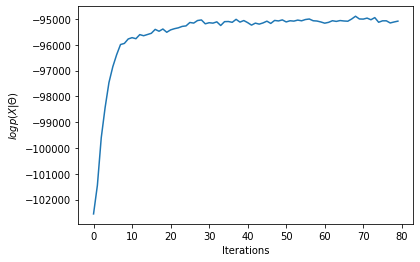

In [19]:
import matplotlib.pyplot as plt
data = plt.plot(log_x_list)
plt.xlabel('Iterations')
plt.ylabel('$log p(X|\Theta)$')

In [20]:
data_algo_1 = log_x_list

In [21]:
print(f'log_px:\n {np.around(log_x_list[-1], 4)}')

assert math.isclose(log_x_list[-1],-95130.3166, rel_tol=1e-2)

print(f'pi_vector:\n {np.around(pi_vector, 4)}')
assert math.isclose(pi_vector[0],0.0236, rel_tol=1e-2)
print(f'theta_matrix[0,:]:\n {np.around(theta_matrix[0,:], 3)}')
assert math.isclose(theta_matrix[0, -1],0.142, rel_tol=1e-2)
print(f'Z_matrix[15,:]:\n {np.around(Z_matrix[15,:], 3)}')
assert math.isclose(Z_matrix[15, 2],1, rel_tol=1e-2)

print(f'z_map[15,:]:\n {np.around(z_map[15,:], 3)}')
assert math.isclose(z_map[15, 1],1, rel_tol=1e-2)




log_px:
 -95085.9854
pi_vector:
 [0.0236 0.212  0.22   0.2724 0.272 ]
theta_matrix[0,:]:
 [0.001 0.001 0.002 0.    0.001 0.001 0.    0.003 0.003 0.    0.001 0.
 0.005 0.004 0.    0.    0.    0.001 0.001 0.    0.    0.    0.003 0.
 0.004 0.001 0.002 0.006 0.    0.001 0.001 0.    0.003 0.001 0.172 0.186
 0.    0.003 0.002 0.002 0.    0.001 0.    0.    0.001 0.001 0.002 0.002
 0.001 0.002 0.    0.001 0.004 0.001 0.002 0.001 0.    0.001 0.002 0.002
 0.003 0.001 0.001 0.    0.003 0.001 0.001 0.001 0.    0.    0.001 0.001
 0.001 0.    0.003 0.002 0.001 0.002 0.    0.001 0.001 0.003 0.001 0.001
 0.    0.001 0.005 0.001 0.002 0.    0.002 0.001 0.001 0.    0.001 0.
 0.004 0.152 0.    0.004 0.    0.004 0.004 0.    0.    0.001 0.003 0.
 0.    0.001 0.002 0.    0.001 0.001 0.002 0.    0.197 0.    0.    0.142]
Z_matrix[15,:]:
 [0 0 1 0 0]
z_map[15,:]:
 [0. 1. 0. 0. 0.]


#### Exercise 2.3.4

This Github repo might be useful: https://github.com/amueller/word_cloud

### Algorithm 2

In [22]:
def Z_XZTheta(X, Z, theta_matrix, alpha_v):
    N, I = X.shape
    K = theta_matrix.shape[0]
    z_probs = np.zeros([N, K])
    z_matrix = np.zeros([N, K])
    alpha_sum =  np.sum(alpha_v)
    z_sum = np.sum(Z, axis=0)
    lik_X =np.exp(X @ np.log(theta_matrix.T))
    for n in range(N):
        z_n =  Z[n, :]
        z_sum_n = z_sum - z_n
        zn_Z = (z_sum_n + alpha_v)/(N -1 + alpha_sum)
        z_probs_n_unnormalized = zn_Z * lik_X[n,:]
        z_probs_n = (z_probs_n_unnormalized / np.sum(z_probs_n_unnormalized)).flatten()

        z_n = np.random.multinomial(n=1, pvals=z_probs_n, size=1).flatten()

        z_probs[n, :] = z_probs_n
        z_matrix[n, :] = z_n
        z_sum = z_sum_n + z_n
    return z_probs, z_matrix


In [23]:
np.random.seed(1234)

alpha_v=1*np.ones(K)
gamma_v=np.ones(I)

pi_vector, theta_matrix, z_matrix =  initialize_parameters(N, K, alpha_v, gamma_v)


z_probs, Z =  Z_XZTheta(X_matrix, z_matrix, theta_matrix, alpha_v)

print(f'z_probs[10,:]:\n {np.around(z_probs[10,:], 3)}')
print(f'Z[10,:]:\n {np.around(Z[10,:], 3)}')
assert math.isclose(z_probs[10, -2],0.147, rel_tol=1e-2)
assert math.isclose(Z[10,2],1, rel_tol=1e-2)

z_probs[10,:]:
 [0.076 0.164 0.609 0.147 0.004]
Z[10,:]:
 [0. 0. 1. 0. 0.]


In [24]:
def fit_collapsed_pi(X, K, alpha_v, gamma_v, burn_in, n_iters):
    N, I = X.shape
    # Initialize
    pi_vector, theta_matrix, z_vector =  initialize_parameters(N, K, alpha_v, gamma_v)
    z_map = np.zeros([N, K])
    log_x_list = []

    for it in range(n_iters):
        for k in range(K):
            theta_matrix[k, :] = thetak_XZ(X, z_vector, k, gamma_v)

        z_probs, z_vector = Z_XZTheta(X, z_vector, theta_matrix, alpha_v)


        log_lik_it = log_likelihood_X(X, z_vector, theta_matrix)
        log_x_list.append(log_lik_it)
        print('ITER: {} | log_lik: {}'.format(str(it), log_lik_it))
        if it > burn_in: z_map += z_vector
    Zk = np.argmax(z_map, axis=-1)
    z_map = np.zeros([N, K])
    for i in range(N):
        z_map[i, Zk[i]] = 1.
    return pi_vector, theta_matrix, z_vector, z_map, log_x_list

In [25]:
np.random.seed(1234)

alpha_v=1.0*np.ones(K)
gamma_v=np.ones(I)

pi_vector, theta_matrix, z_vector, z_map, log_x_list = fit_collapsed_pi(X_matrix, K, alpha_v, gamma_v, 
                                                                        burn_in=20, n_iters=50)

ITER: 0 | log_lik: -102559.13775768007
ITER: 1 | log_lik: -101444.95518619442
ITER: 2 | log_lik: -99857.75052971166
ITER: 3 | log_lik: -98802.72557167934
ITER: 4 | log_lik: -97944.53712724098
ITER: 5 | log_lik: -97136.4644021177
ITER: 6 | log_lik: -96737.02705846977
ITER: 7 | log_lik: -96247.92952606556
ITER: 8 | log_lik: -95853.82233481246
ITER: 9 | log_lik: -95773.45116447515
ITER: 10 | log_lik: -95622.5144382557
ITER: 11 | log_lik: -95472.80112218249
ITER: 12 | log_lik: -95522.3921689909
ITER: 13 | log_lik: -95294.66412646713
ITER: 14 | log_lik: -95383.29082012142
ITER: 15 | log_lik: -95404.78467482638
ITER: 16 | log_lik: -95281.21739551796
ITER: 17 | log_lik: -95251.20506977361
ITER: 18 | log_lik: -95339.14271425933
ITER: 19 | log_lik: -95243.88874342809
ITER: 20 | log_lik: -95248.85468193113
ITER: 21 | log_lik: -95205.20776639697
ITER: 22 | log_lik: -95225.4093787161
ITER: 23 | log_lik: -95246.8255742146
ITER: 24 | log_lik: -95251.81580696983
ITER: 25 | log_lik: -95125.19286723327

Text(0, 0.5, '$log p(X|\\Theta)$')

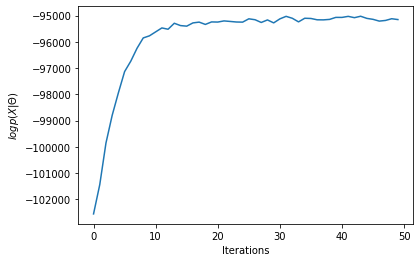

In [26]:
import matplotlib.pyplot as plt
data = plt.plot(log_x_list)
plt.xlabel('Iterations')
plt.ylabel('$log p(X|\Theta)$')

In [27]:
data_algo_2 = log_x_list

### Algorithm 3

In [28]:
def beta_function(param_v):
    denominator = scipy.special.gamma(np.sum(param_v))
    print(denominator)
    numerator = np.prod([scipy.special.gamma(p) for p in param_v])
    return numerator / denominator


def ratio_beta_function(gamma_v, count_v):
    gamma_v = [int(g) for g in gamma_v.flatten()]
    count_v = [int(g) for g in count_v.flatten()]
    gamma_sum = np.sum(gamma_v)
    Wn = np.sum(count_v)
    num_terms = list()
    for gamma_m, count_m in zip(gamma_v, count_v):
        num_terms.append(np.prod([i for i in range(gamma_m, gamma_m + count_m)]))

    num = np.prod(num_terms)

    den = np.prod([j for j in range(gamma_sum, gamma_sum + Wn)])

    return num / den


def log_ratio_beta_function(gamma_v, count_v):
    gamma_v = gamma_v.flatten()
    gamma_sum = np.sum(gamma_v)
    Wn = int(np.sum(count_v))
    num_terms = list()
    for gamma_m, count_m in zip(gamma_v, count_v):
        if count_m == 0: continue
        term_m = list(map(lambda x: np.log(x + gamma_m), list(range(count_m))))

        num_terms.append(np.sum(term_m))
    num = np.sum(num_terms)

    den = np.sum([np.log(gamma_sum + j) for j in range(0, Wn)])

    out = num - den
    return out


In [29]:
def zn_Z_function(z_matrix, n, alpha_v):
    N = z_matrix.shape[0]
    z_matrix_n = np.delete(z_matrix, n, axis=0)

    count = np.sum(z_matrix_n, axis=0)

    numerator = count + alpha_v
    denominator = N - 1 + np.sum(alpha_v)
    return numerator / denominator


def gamma_pp_v_k(z_matrix_n, x_matrix_n, k, gamma_v):
    z_k = (z_matrix_n[:, [k]].T == 1).flatten()
    gamma_pp_v = gamma_v + np.sum(x_matrix_n[z_k, :], axis=0)  # [1, N-1] * [N-1, I]
    return gamma_pp_v
    
def predictive_likelihood(z_matrix, X, n, gamma_v):
    N, K = z_matrix.shape
    z_matrix_n = np.delete(z_matrix, n, axis=0)
    count_nm = X[n, :]  # [1, I]
    x_matrix_n = np.delete(X, n, axis=0)
    predictive_lik = np.zeros(K)
    for k in range(K):
        gamma_pp_v = gamma_pp_v_k(z_matrix_n, x_matrix_n, k, gamma_v)

        predictive_lik[k] = np.exp(log_ratio_beta_function(gamma_pp_v, count_nm))

    return predictive_lik

In [30]:
def fit_collapsed_pi_theta(X, K, alpha_v, gamma_v, burn_in, n_iters):
    N, I = X.shape
    X = X.astype(int)
    pi_vector, theta_matrix, z_vector =  initialize_parameters(N, K, alpha_v, gamma_v)
    z_map = np.zeros([N, K])
    z_probs = np.zeros([N, K])
    log_x_list = []
    for it in range(n_iters):
        
        for n in range(N):
            zn_Z = zn_Z_function(z_vector, n, alpha_v)
            pred_lik = predictive_likelihood(z_vector, X, n, gamma_v)
            z_probs[n, :] = zn_Z * pred_lik / np.sum(zn_Z * pred_lik)

            z_vector[n, :] = np.random.multinomial(n=1, pvals=z_probs[n, :], size=1)

        for k in range(K):
            theta_matrix[k,:] = thetak_XZ(X, z_vector, k, gamma_v)
        log_lik_it = log_likelihood_X(X, z_vector, theta_matrix)
        log_x_list.append(log_lik_it)

        print('ITER: {} | log_lik: {}'.format(str(it), log_lik_it))

        if it > burn_in: z_map += z_vector
    Zk = np.argmax(z_map, axis=-1)
    z_map = np.zeros([N, K])
    for i in range(N):
        z_map[i, Zk[i]] = 1.
    return pi_vector, theta_matrix, z_vector, z_map, log_x_list

In [31]:
np.random.seed(1234)

alpha_v=1*np.ones(K)
gamma_v=np.ones(I)

pi_vector, theta_matrix, z_vector, z_map, log_x_list = fit_collapsed_pi_theta(X_matrix, K, alpha_v, gamma_v, 
                                                                              burn_in=3, n_iters=10)

ITER: 0 | log_lik: -101250.93189820612
ITER: 1 | log_lik: -98993.1880305202
ITER: 2 | log_lik: -97736.05883526699
ITER: 3 | log_lik: -96814.40911466107
ITER: 4 | log_lik: -96141.6368338282
ITER: 5 | log_lik: -95662.13875786256
ITER: 6 | log_lik: -95580.91738674187
ITER: 7 | log_lik: -95321.23685231026
ITER: 8 | log_lik: -95213.28637060046
ITER: 9 | log_lik: -94981.55894823025


Text(0, 0.5, '$log p(X|\\Theta)$')

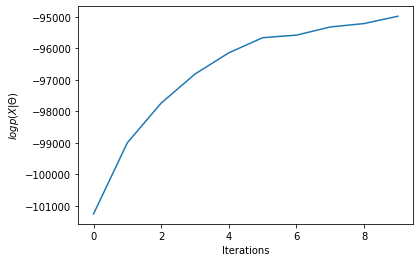

In [32]:
import matplotlib.pyplot as plt
data = plt.plot(log_x_list)
plt.xlabel('Iterations')
plt.ylabel('$log p(X|\Theta)$')

In [33]:
data_algo_3 = log_x_list 

### Exercise 2.4
Explain the differences in the convergence speed of the algorithms in terms of number of iterations and time. What is the reason behind the differences?

YOUR ANSWER HERE

 Below you can add the code you consider necessary to answer Exercise 2.4.

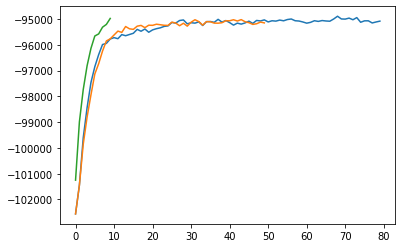

In [34]:
import matplotlib.pyplot as plt
plt.plot(data_algo_1)
plt.plot(data_algo_2)
plt.plot(data_algo_3)
plt.show()

As we observe from the above combined graph Algorithm 3(green) converges much faster than Algo 1(blue) and 2(orange). Both Algo 1 and 2 perform nearly the same but around iteration 10 one can observe a slight difference in them.  